In [7]:
import pandas as pd
import numpy as np
import talib
import pandas_profiling as pdp
import sweetviz as sv

import os
import sys
from pygam import s, LinearGAM
import category_encoders as ce
from typing import List, Dict

import matplotlib.pyplot as plt
import seaborn as sns

import ptitprince
from matplotlib_venn import venn2
plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'

from common_module.utils.plot import (
    plot_venn,
    plot_histogram,
    plot_raincloud,
    plot_heatmap,
    plot_histgram_for_valid,
    plot_lineargam,
    plot_feature_importance_for_valid
)
from common_module.utils.summarize import (
    get_pandas_profiling,
    get_sweetviz_report
)
from common_module.utils.preprocessor import (
    OrdinalEncodingBlock,
    CountEncodingBlock,
    GroupingBlock
)
from common_module.utils.format_df import format_df

# from atma_coffee.modules.config_manager import ConfigManager

sys.path.append("../")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [10]:
input_path = "../input/"
output_path = "../output/"

In [12]:
df_train_origin = pd.read_csv(os.path.join(input_path, "train_data.csv"), encoding="utf-8-sig")
df_test_origin = pd.read_csv(os.path.join(input_path, "test_data.csv"), encoding="utf-8-sig")
df_pub_land_price = pd.read_csv(os.path.join(input_path, "published_land_price.csv"), encoding="utf-8-sig")

print("■ train data", "="*30)
display(df_train_origin.shape)
display(df_train_origin.head(1))

print("■ test data", "="*30)
display(df_test_origin.shape)
display(df_test_origin.head(1))

print("■ pub_land_price", "="*30)
display(df_pub_land_price.shape)
display(df_pub_land_price.head(1))

■ train data ==============================


(356344, 28)

,id,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,y
0,1,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,1,２ＬＤＫ,55,NaN,NaN,NaN,昭和59年,ＳＲＣ,NaN,住宅,NaN,NaN,NaN,商業地域,80.0,600.0,2017年第４四半期,改装済,NaN,66.0


■ test data ==============================


(34844, 27)

,id,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等
0,1,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,3,１ＬＤＫ,35,NaN,NaN,NaN,昭和60年,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,80.0,700.0,2018年第４四半期,未改装,NaN


■ pub_land_price ==============================


(2602, 116)

,id,経度,緯度,所在地コード,用途,連番,年次,前年所在地コード,前年用途,前年連番,市区町村名,住居表示,行政,地積,利用の現況,利用状況表示,建物構造,施設,形状区分,間口（比率）,奥行（比率）,階層（地上）,階層（地下）,前面道路区分,前面道路の方位区分,前面道路の幅員,前面道路の駅前区分,前面道路の舗装状況,側道区分,側道方位区分,交通施設との近接区分,周辺の土地の利用の現況,駅名,駅距離,用途区分,防火区分,都市計画区分,森林区分,公園区分,建蔽率,容積率,共通地点区分,選定年次ビット,Ｓ５８価格,Ｓ５９価格,Ｓ６０価格,Ｓ６１価格,Ｓ６２価格,Ｓ６３価格,Ｈ１価格,Ｈ２価格,Ｈ３価格,Ｈ４価格,Ｈ５価格,Ｈ６価格,Ｈ７価格,Ｈ８価格,Ｈ９価格,Ｈ１０価格,Ｈ１１価格,Ｈ１２価格,Ｈ１３価格,Ｈ１４価格,Ｈ１５価格,Ｈ１６価格,Ｈ１７価格,Ｈ１８価格,Ｈ１９価格,Ｈ２０価格,Ｈ２１価格,Ｈ２２価格,Ｈ２３価格,Ｈ２４価格,Ｈ２５価格,Ｈ２６価格,Ｈ２７価格,Ｈ２８価格,Ｈ２９価格,Ｈ３０価格,Ｈ３１価格,属性移動Ｓ５９,属性移動Ｓ６０,属性移動Ｓ６１,属性移動Ｓ６２,属性移動Ｓ６３,属性移動Ｈ１,属性移動Ｈ２,属性移動Ｈ３,属性移動Ｈ４,属性移動Ｈ５,属性移動Ｈ６,属性移動Ｈ７,属性移動Ｈ８,属性移動Ｈ９,属性移動Ｈ１０,属性移動Ｈ１１,属性移動Ｈ１２,属性移動Ｈ１３,属性移動Ｈ１４,属性移動Ｈ１５,属性移動Ｈ１６,属性移動Ｈ１７,属性移動Ｈ１８,属性移動Ｈ１９,属性移動Ｈ２０,属性移動Ｈ２１,属性移動Ｈ２２,属性移動Ｈ２３,属性移動Ｈ２４,属性移動Ｈ２５,属性移動Ｈ２６,属性移動Ｈ２７,属性移動Ｈ２８,属性移動Ｈ２９,属性移動Ｈ３０,属性移動Ｈ３１
0,1,500891.116,123138.601,13364,0,1,2019,13364,0,1,神津島,東京都 神津島村９９５番,13364,224,10000000000000000,_,W2,101,_,10,12,2,0,村道,南,22,_,_,_,_,_,一般住宅のほか民宿、店舗等が混在する住宅地域,キャンドゥ前,460,_,_,非線引,_,_,70,200,False,0000000000011111111111111111111111111,0,0,0,0,0,0,0,0,0,0,0,7600,7600,7600,7600,7600,7600,7600,7500,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,0,0,0,0,0,0,0,0,0,0,40000000000000,10000000000000,10000000000000,10000000000000,10000001000001,10000001000001,10000000000011,10000000000000,10000000000000,10000000000000,10000100000000,10000000000001,10000000000000,10000000000000,10000000000000,10000010000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000010000000


In [13]:
df_list = [df_train_origin, df_test_origin, df_pub_land_price]
output_name_list = ["train_profile", "test_profile", "land_price_profile"]
for _df, output_name in zip(df_list, output_name_list):
    get_pandas_profiling(
        df=_df,
        output_path=output_path,
        output_name=output_name
    )

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [14]:
get_sweetviz_report(train=df_train_origin, test=df_test_origin, output_path=output_path, output_name="train_vs_test_profile")

                                             |                                                                …

Report ../output/train_vs_test_profile.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## yについて

### 外れ値のような大きな値がある

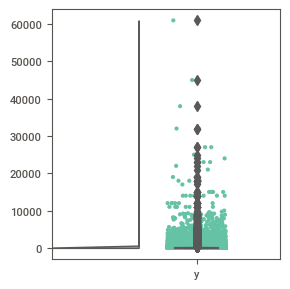

In [29]:
# origin
plot_raincloud(df=df_train_origin, target_cols=["y"], figsize=(3, 3))

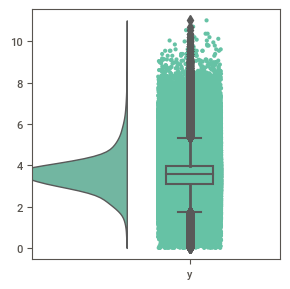

In [33]:
# log1p
_df = df_train_origin[["y"]].copy()
_df["y"] = np.log1p(_df["y"])
plot_raincloud(df=_df, target_cols=["y"], figsize=(3, 3))

In [20]:
df_train_origin["y"].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

count    356344.000000
mean         65.434766
std         315.011339
min           0.000500
5%            8.000000
10%          12.000000
25%          21.000000
50%          35.000000
75%          53.000000
90%          91.000000
95%         160.000000
max       61000.000000
Name: y, dtype: float64

In [24]:
df_train_origin[df_train_origin["y"] > 30000].sort_values("y", ascending=False)

,id,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,y
48111,48112,宅地(土地と建物),商業地,13103,東京都,港区,赤坂,赤坂(東京),4,NaN,2000㎡以上,不整形,50.0m以上,2000㎡以上,平成5年,ＳＲＣ,共同住宅、事務所、駐車場、店舗,NaN,南西,区道,9.0,商業地域,80.0,500.0,2011年第４四半期,NaN,NaN,61000.0
320210,320211,宅地(土地),住宅地,13122,東京都,葛飾区,新宿,金町,9,NaN,2000㎡以上,不整形,50.0m以上,NaN,NaN,NaN,NaN,NaN,南,区道,16.0,工業地域,60.0,200.0,2008年第１四半期,NaN,NaN,45000.0
76360,76361,宅地(土地と建物),商業地,13101,東京都,千代田区,四番町,市ケ谷,4,NaN,2000㎡以上,長方形,50.0m以上,2000㎡以上,昭和36年,ＳＲＣ,事務所,NaN,西,都道,15.0,商業地域,80.0,600.0,2007年第４四半期,NaN,NaN,38000.0
62445,62446,宅地(土地と建物),商業地,13102,東京都,中央区,晴海,勝どき,10,NaN,2000㎡以上,ほぼ長方形,50.0m以上,2000㎡以上,平成24年,鉄骨造,事務所、店舗,NaN,北西,都道,50.0,準工業地域,60.0,400.0,2012年第４四半期,NaN,NaN,32000.0
112505,112506,宅地(土地と建物),商業地,13107,東京都,墨田区,太平,錦糸町,4,NaN,2000㎡以上,不整形,50.0m以上,2000㎡以上,平成18年,ＳＲＣ,事務所、倉庫,NaN,西,都道,22.0,商業地域,80.0,500.0,2009年第２四半期,NaN,NaN,32000.0


In [45]:
# df_train_origin[df_train_origin["市区町村コード"] == 13107]
# df_pub_land_price[df_pub_land_price["所在地コード"] == 13107]
df_pub_land_price[df_pub_land_price["所在地コード"] == 13107].head(2)
# df_train_origin[df_train_origin["id"] == 2286]

,id,経度,緯度,所在地コード,用途,連番,年次,前年所在地コード,前年用途,前年連番,市区町村名,住居表示,行政,地積,利用の現況,利用状況表示,建物構造,施設,形状区分,間口（比率）,奥行（比率）,階層（地上）,階層（地下）,前面道路区分,前面道路の方位区分,前面道路の幅員,前面道路の駅前区分,前面道路の舗装状況,側道区分,側道方位区分,交通施設との近接区分,周辺の土地の利用の現況,駅名,駅距離,用途区分,防火区分,都市計画区分,森林区分,公園区分,建蔽率,容積率,共通地点区分,選定年次ビット,Ｓ５８価格,Ｓ５９価格,Ｓ６０価格,Ｓ６１価格,Ｓ６２価格,Ｓ６３価格,Ｈ１価格,Ｈ２価格,Ｈ３価格,Ｈ４価格,Ｈ５価格,Ｈ６価格,Ｈ７価格,Ｈ８価格,Ｈ９価格,Ｈ１０価格,Ｈ１１価格,Ｈ１２価格,Ｈ１３価格,Ｈ１４価格,Ｈ１５価格,Ｈ１６価格,Ｈ１７価格,Ｈ１８価格,Ｈ１９価格,Ｈ２０価格,Ｈ２１価格,Ｈ２２価格,Ｈ２３価格,Ｈ２４価格,Ｈ２５価格,Ｈ２６価格,Ｈ２７価格,Ｈ２８価格,Ｈ２９価格,Ｈ３０価格,Ｈ３１価格,属性移動Ｓ５９,属性移動Ｓ６０,属性移動Ｓ６１,属性移動Ｓ６２,属性移動Ｓ６３,属性移動Ｈ１,属性移動Ｈ２,属性移動Ｈ３,属性移動Ｈ４,属性移動Ｈ５,属性移動Ｈ６,属性移動Ｈ７,属性移動Ｈ８,属性移動Ｈ９,属性移動Ｈ１０,属性移動Ｈ１１,属性移動Ｈ１２,属性移動Ｈ１３,属性移動Ｈ１４,属性移動Ｈ１５,属性移動Ｈ１６,属性移動Ｈ１７,属性移動Ｈ１８,属性移動Ｈ１９,属性移動Ｈ２０,属性移動Ｈ２１,属性移動Ｈ２２,属性移動Ｈ２３,属性移動Ｈ２４,属性移動Ｈ２５,属性移動Ｈ２６,属性移動Ｈ２７,属性移動Ｈ２８,属性移動Ｈ２９,属性移動Ｈ３０,属性移動Ｈ３１
2285,2286,503247.424,128487.884,13107,0,4,2019,13107,0,4,墨田,東京都 墨田区千歳１－２－１０,13107,431,10000000000000100,共同住宅,RC9,111,_,10,15,9,0,区道,南西,110,_,_,_,_,_,マンション、倉庫、事務所等が混在する住宅地域,森下,650,準工,防火,市街化,_,_,60,400,False,0000000000001111111111111111111111111,0,0,0,0,0,0,0,0,0,0,0,0,790000,650000,583000,552000,501000,468000,441000,418000,410000,406000,404000,405000,456000,510000,480000,456000,448000,440000,440000,448000,457000,473000,499000,536000,576000,0,0,0,0,0,0,0,0,0,0,0,40000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000010,10000000000000,10000000000000,10011000000000,20011000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,20000000000000,20000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000
2288,2289,503248.774,128498.663,13107,5,4,2019,13107,5,4,墨田,東京都 墨田区両国２－１０－５,13107,307,100000000000000,_,SRC7F1B,111,不整形,10,15,7,1,国道,北,270,_,_,側道,東,_,中高層の店舗、事務所等が多い商業地域,両国,310,商業,防火,市街化,_,_,80,600,False,0000111111111111111111111111111111111,0,0,0,0,3450000,5550000,5900000,6100000,6200000,5450000,4230000,3520000,2290000,1520000,1150000,1050000,935000,840000,750000,673000,638000,624000,618000,618000,710000,845000,793000,730000,718000,703000,703000,717000,729000,750000,780000,832000,933000,0,0,0,40000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000010000000,10000000000000,10000010000000,10000000000000,10000000000000,10000000000000,10000000000010,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000010000000


In [46]:
df_pub_land_price["年次"].value_counts()

2019    2602
Name: 年次, dtype: int64

In [25]:
df_train_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356344 entries, 0 to 356343
Data columns (total 28 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          356344 non-null  int64  
 1   種類          356344 non-null  object 
 2   地域          196938 non-null  object 
 3   市区町村コード     356344 non-null  int64  
 4   都道府県名       356344 non-null  object 
 5   市区町村名       356344 non-null  object 
 6   地区名         356098 non-null  object 
 7   最寄駅：名称      354793 non-null  object 
 8   最寄駅：距離（分）   346215 non-null  object 
 9   間取り         153776 non-null  object 
 10  面積（㎡）       356344 non-null  object 
 11  土地の形状       196543 non-null  object 
 12  間口          180263 non-null  object 
 13  延床面積（㎡）     120143 non-null  object 
 14  建築年         273503 non-null  object 
 15  建物の構造       277515 non-null  object 
 16  用途          275283 non-null  object 
 17  今後の利用目的     111379 non-null  object 
 18  前面道路：方位     196514 non-null  object 
 19  前面

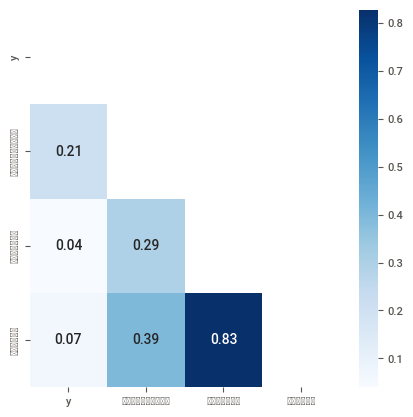

In [27]:
plot_heatmap(df=df_train_origin, target_cols=["y", "前面道路：幅員（ｍ）", "建ぺい率（％）", "容積率（％）"], figsize=(5, 5))

In [34]:
df_pub_land_price.head(2)

,id,経度,緯度,所在地コード,用途,連番,年次,前年所在地コード,前年用途,前年連番,市区町村名,住居表示,行政,地積,利用の現況,利用状況表示,建物構造,施設,形状区分,間口（比率）,奥行（比率）,階層（地上）,階層（地下）,前面道路区分,前面道路の方位区分,前面道路の幅員,前面道路の駅前区分,前面道路の舗装状況,側道区分,側道方位区分,交通施設との近接区分,周辺の土地の利用の現況,駅名,駅距離,用途区分,防火区分,都市計画区分,森林区分,公園区分,建蔽率,容積率,共通地点区分,選定年次ビット,Ｓ５８価格,Ｓ５９価格,Ｓ６０価格,Ｓ６１価格,Ｓ６２価格,Ｓ６３価格,Ｈ１価格,Ｈ２価格,Ｈ３価格,Ｈ４価格,Ｈ５価格,Ｈ６価格,Ｈ７価格,Ｈ８価格,Ｈ９価格,Ｈ１０価格,Ｈ１１価格,Ｈ１２価格,Ｈ１３価格,Ｈ１４価格,Ｈ１５価格,Ｈ１６価格,Ｈ１７価格,Ｈ１８価格,Ｈ１９価格,Ｈ２０価格,Ｈ２１価格,Ｈ２２価格,Ｈ２３価格,Ｈ２４価格,Ｈ２５価格,Ｈ２６価格,Ｈ２７価格,Ｈ２８価格,Ｈ２９価格,Ｈ３０価格,Ｈ３１価格,属性移動Ｓ５９,属性移動Ｓ６０,属性移動Ｓ６１,属性移動Ｓ６２,属性移動Ｓ６３,属性移動Ｈ１,属性移動Ｈ２,属性移動Ｈ３,属性移動Ｈ４,属性移動Ｈ５,属性移動Ｈ６,属性移動Ｈ７,属性移動Ｈ８,属性移動Ｈ９,属性移動Ｈ１０,属性移動Ｈ１１,属性移動Ｈ１２,属性移動Ｈ１３,属性移動Ｈ１４,属性移動Ｈ１５,属性移動Ｈ１６,属性移動Ｈ１７,属性移動Ｈ１８,属性移動Ｈ１９,属性移動Ｈ２０,属性移動Ｈ２１,属性移動Ｈ２２,属性移動Ｈ２３,属性移動Ｈ２４,属性移動Ｈ２５,属性移動Ｈ２６,属性移動Ｈ２７,属性移動Ｈ２８,属性移動Ｈ２９,属性移動Ｈ３０,属性移動Ｈ３１
0,1,500891.116,123138.601,13364,0,1,2019,13364,0,1,神津島,東京都 神津島村９９５番,13364,224,10000000000000000,_,W2,101,_,10,12,2,0,村道,南,22,_,_,_,_,_,一般住宅のほか民宿、店舗等が混在する住宅地域,キャンドゥ前,460,_,_,非線引,_,_,70,200,False,0000000000011111111111111111111111111,0,0,0,0,0,0,0,0,0,0,0,7600,7600,7600,7600,7600,7600,7600,7500,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,7600,0,0,0,0,0,0,0,0,0,0,40000000000000,10000000000000,10000000000000,10000000000000,10000001000001,10000001000001,10000000000011,10000000000000,10000000000000,10000000000000,10000100000000,10000000000001,10000000000000,10000000000000,10000000000000,10000010000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000010000000
1,2,500894.320,123142.529,13364,5,1,2019,13364,5,1,神津島,東京都 神津島村８４１番,13364,203,11000000000000000,_,RC2,101,_,15,10,2,0,村道,西,35,_,_,_,_,_,小規模小売店舗、民宿等の建ち並ぶ近隣商業地域,キャンドゥ前,550,_,_,非線引,_,_,70,200,False,0000000000001111111111111111111111111,0,0,0,0,0,0,0,0,0,0,0,0,9500,9500,9500,9500,9500,9500,9400,9500,9500,9500,9500,9500,9500,9500,9500,9500,9500,9500,9500,9500,9500,9500,9500,9500,9500,0,0,0,0,0,0,0,0,0,0,0,40000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000011,10000000000000,10000000000000,10000000000000,10000100000000,10000000000001,10010000000000,10000000000000,10000000000000,10000010000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000000000000,10000010000000


## 各列の状態

In [68]:
# train & test結合
class ConcatTrainTestDf:
    def __init__(self, train: pd.DataFrame, test: pd.DataFrame, with_log1p_y: bool):
        self.df_train = train.copy()
        self.df_test = test.copy()
        self.with_log1p_y = with_log1p_y

        # 結合前にy列を整える
        self._set_y_column()

    def concat_df(self):
        df_concat = pd.concat([self.df_train, self.df_test], ignore_index=True, sort=False)
        return df_concat

    def _set_y_column(self):
        self.df_test["y"] = np.nan  # 仮の値を入れる

        # log変換
        if self.with_log1p_y:
            self.df_train["log1p_y"] = np.log1p(self.df_train["y"])
            self.df_test["log1p_y"] = np.nan  # 仮の値を入れる

        # data_typeの追加
        self.df_train["data_type"] = "train"
        self.df_test["data_type"] = "test"

ins_concat = ConcatTrainTestDf(train=df_train_origin, test=df_test_origin, with_log1p_y=True)
df_all = ins_concat.concat_df()

display(df_all.shape)
display(df_all.head(1))

(391188, 30)

,id,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,y,log1p_y,data_type
0,1,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,1,２ＬＤＫ,55,NaN,NaN,NaN,昭和59年,ＳＲＣ,NaN,住宅,NaN,NaN,NaN,商業地域,80.0,600.0,2017年第４四半期,改装済,NaN,66.0,4.204693,train


In [147]:
df_all["地区名"].unique()

array(['飯田橋', '一番町', '岩本町', ..., '大字長岡下師岡', '切欠', '字金長'], dtype=object)

In [145]:
df_all["市区町村名"].unique()

array(['千代田区', '中央区', '港区', '新宿区', '文京区', '台東区', '墨田区', '江東区', '品川区',
       '目黒区', '大田区', '世田谷区', '渋谷区', '中野区', '杉並区', '豊島区', '北区', '荒川区',
       '板橋区', '練馬区', '足立区', '葛飾区', '江戸川区', '八王子市', '立川市', '武蔵野市', '三鷹市',
       '青梅市', '府中市', '昭島市', '調布市', '町田市', '小金井市', '小平市', '日野市', '東村山市',
       '国分寺市', '国立市', '福生市', '狛江市', '東大和市', '清瀬市', '東久留米市', '武蔵村山市',
       '多摩市', '稲城市', '羽村市', 'あきる野市', '西東京市', '西多摩郡瑞穂町', '西多摩郡日の出町',
       '西多摩郡檜原村', '西多摩郡奥多摩町', '大島町', '新島村', '神津島村', '三宅村', '八丈町', '小笠原村'],
      dtype=object)

In [69]:
# 2000㎡以上などの文字列が含まれている
df_all["面積（㎡）"].unique()

array(['55', '20', '45', '80', '70', '50', '85', '210', '105', '65', '25',
       '75', '100', '220', '30', '35', '115', '60', '95', '40', '110',
       '1200', '230', '125', '15', '170', '90', '300', '165', '200',
       '155', '180', '150', '480', '190', '120', '130', '510', '310',
       '195', '10', '260', '650', '500', '330', '140', '135', '380',
       '410', '270', '360', '730', '420', '280', '590', '560', '175',
       '145', '350', '460', '780', '1700', '240', '185', '160', '870',
       '540', '1000', '2000㎡以上', '290', '340', '530', '580', '390', '610',
       '1400', '1300', '490', '430', '400', '320', '940', '370', '980',
       '670', '1100', '910', '450', '660', '630', '1800', '470', '440',
       '250', '520', '550', '820', '1600', '640', '690', '840', '700',
       '850', '1500', '570', '900', '620', '920', '790', '890', '750',
       '960', '720', '950', '970', '830', '760', '710', '680', '740',
       '930', '600', '860', '800', '990', '770', '810', '880', '1900',
   

In [70]:
# 林地、農地は面積が広く、価格が小さい -> 補正する必要あり
df = df_all[df_all["data_type"] == "train"][["id", "種類", "面積（㎡）", "y"]].copy()
df["面積（㎡）"] = df["面積（㎡）"].str.replace("㎡以上", "")
df["面積（㎡）"] = pd.to_numeric(df["面積（㎡）"])
df.groupby("種類", as_index=False)[["面積（㎡）", "y"]].median()

,種類,面積（㎡）,y
0,中古マンション等,50.0,25.0
1,宅地(土地),125.0,42.0
2,宅地(土地と建物),105.0,44.0
3,林地,1400.0,3.0
4,農地,830.0,4.8


In [51]:
# 種類 -> 問題なし
df_all["種類"].unique()

array(['中古マンション等', '宅地(土地と建物)', '宅地(土地)', '林地', '農地'], dtype=object)

In [52]:
# 地域 -> 問題なし
df_all["地域"].unique()

array([nan, '商業地', '住宅地', '工業地', '宅地見込地'], dtype=object)

In [53]:
# 都道府県名 -> 東京しかないので情報として不要
df_all["都道府県名"].unique()

array(['東京都'], dtype=object)

In [54]:
# 市区町村名 -> 問題なし
df_all["市区町村名"].unique()

array(['千代田区', '中央区', '港区', '新宿区', '文京区', '台東区', '墨田区', '江東区', '品川区',
       '目黒区', '大田区', '世田谷区', '渋谷区', '中野区', '杉並区', '豊島区', '北区', '荒川区',
       '板橋区', '練馬区', '足立区', '葛飾区', '江戸川区', '八王子市', '立川市', '武蔵野市', '三鷹市',
       '青梅市', '府中市', '昭島市', '調布市', '町田市', '小金井市', '小平市', '日野市', '東村山市',
       '国分寺市', '国立市', '福生市', '狛江市', '東大和市', '清瀬市', '東久留米市', '武蔵村山市',
       '多摩市', '稲城市', '羽村市', 'あきる野市', '西東京市', '西多摩郡瑞穂町', '西多摩郡日の出町',
       '西多摩郡檜原村', '西多摩郡奥多摩町', '大島町', '新島村', '神津島村', '三宅村', '八丈町', '小笠原村'],
      dtype=object)

In [55]:
# 地区名 -> 問題なし
df_all["地区名"].unique()

array(['飯田橋', '一番町', '岩本町', ..., '大字長岡下師岡', '切欠', '字金長'], dtype=object)

In [56]:
# 最寄駅：名称 -> 早稲田(メトロ), 早稲田(都電)は同じか？
df_all["最寄駅：名称"].unique()

array(['飯田橋', '九段下', '水道橋', '麹町', '半蔵門', '秋葉原', '岩本町', '神田(東京)', '小伝馬町',
       '新日本橋', '馬喰町', '大手町(東京)', '小川町(東京)', '溜池山王', '淡路町', '新御茶ノ水', '浅草橋',
       '神保町', '御茶ノ水', '竹橋', '四ツ谷', '市ケ谷', '末広町(東京)', '湯島', '永田町', '馬喰横山',
       '日比谷', '新富町(東京)', '築地', '八丁堀(東京)', '勝どき', '京橋(東京)', '宝町(東京)', '東京',
       '銀座', '銀座一丁目', '汐留', '新橋', '築地市場', '東銀座', '茅場町', '月島', '日本橋(東京)',
       '水天宮前', '人形町', '三越前', '浜町', '東日本橋', '青山一丁目', '赤坂(東京)', '赤坂見附',
       '乃木坂', '六本木', '麻布十番', '神谷町', '六本木一丁目', '芝浦ふ頭', '竹芝', '田町(東京)',
       '浜松町', '日の出', '表参道', '外苑前', '北品川', '品川', '天王洲アイル', nan, '赤羽橋',
       '芝公園', '大門(東京)', '三田(東京)', '泉岳寺', '御成門', '白金台', '白金高輪', '広尾',
       '高輪台', '目黒', '内幸町', 'お台場海浜公園', '虎ノ門', '曙橋', '四谷三丁目', '江戸川橋', '神楽坂',
       '牛込柳町', '牛込神楽坂', '早稲田(メトロ)', '新大久保', '高田馬場', '西早稲田', '東新宿', '新宿',
       '新宿三丁目', '落合(東京)', '下落合', '中井', '東中野', '若松河田', '大久保(東京)', '中野坂上',
       '西新宿', '信濃町', '椎名町', '目白', '新宿御苑前', '国立競技場', '千駄ケ谷', '新井薬師前',
       '落合南長崎', '新江古田', '東長崎', '新宿西口', '都庁前', '西新宿五丁目', '初台',

In [57]:
# 最寄駅：距離（分）
df_all["最寄駅：距離（分）"].unique()

array(['1', '5', '3', '4', '2', nan, '8', '7', '6', '0', '11', '10', '9',
       '12', '30分?60分', '13', '14', '16', '15', '19', '20', '18', '21',
       '2H?', '1H30?2H', '23', '25', '17', '29', '28', '26', '24', '22',
       '1H?1H30', '27'], dtype=object)

array(['２ＬＤＫ', '１Ｋ', '１ＬＤＫ', '１Ｒ', nan, '３ＬＤＫ', '１ＤＫ＋Ｓ', '３ＤＫ', '１ＤＫ',
       '２ＤＫ', 'オープンフロア', '４ＬＤＫ', '１Ｋ＋Ｓ', '１ＬＤＫ＋Ｓ', '２ＬＤＫ＋Ｓ', 'スタジオ', '２Ｋ',
       '２ＤＫ＋Ｓ', '３ＬＤＫ＋Ｓ', '３Ｋ', '４ＤＫ', '５ＬＤＫ＋Ｓ', '７ＬＤＫ', '２Ｋ＋Ｓ', 'メゾネット',
       '５ＬＤＫ', '３ＤＫ＋Ｓ', '４Ｋ', '４ＬＤＫ＋Ｓ', '２ＬＤ', '３ＬＫ', '１Ｒ＋Ｓ', '１ＬＫ',
       '２ＬＤ＋Ｓ', '５ＤＫ', '１Ｌ', '２ＬＫ＋Ｓ', '６ＬＤＫ', '２ＬＫ', '１Ｌ＋Ｓ', '６ＬＤＫ＋Ｓ',
       '６ＤＫ', '４ＤＫ＋Ｓ', '３Ｋ＋Ｓ', '３ＬＤ＋Ｓ', '１ＬＤ＋Ｓ', '３ＬＤ', '２Ｄ', '３ＬＤＫ＋Ｋ'],
      dtype=object)

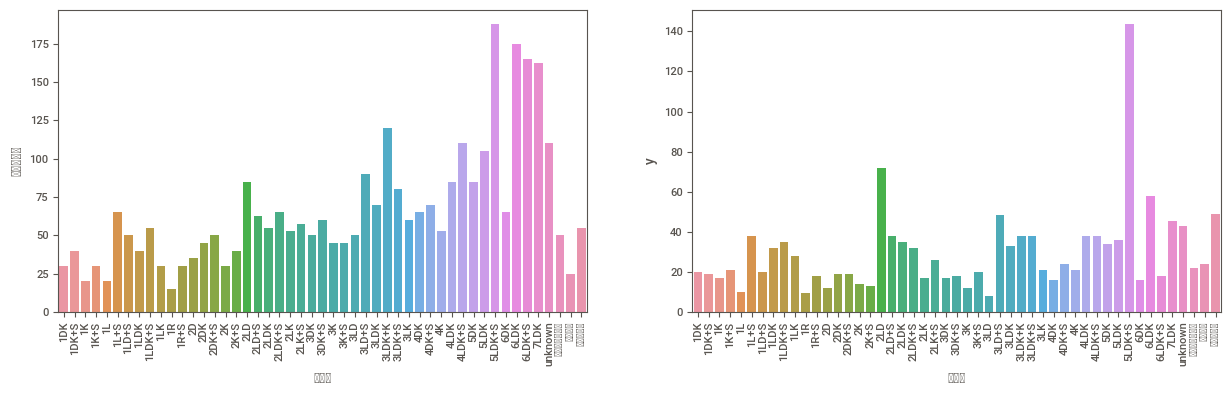

In [189]:
# 間取り
display(df_all["間取り"].unique())

import unicodedata
df = df_all[df_all["data_type"] == "train"][["id", "間取り", "面積（㎡）", "y"]].copy()
df["面積（㎡）"] = df["面積（㎡）"].str.replace("㎡以上", "")
df["面積（㎡）"] = pd.to_numeric(df["面積（㎡）"])
df["間取り"] = df["間取り"].fillna("unknown")  # nanがfloatになり変換できないため
df["間取り"] = df["間取り"].map(lambda x: unicodedata.normalize("NFKC", x))

plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
df_plot = df.groupby("間取り", as_index=False)["面積（㎡）"].median()
sns.barplot(data=df_plot, x="間取り", y="面積（㎡）")
plt.xticks(rotation=90);

plt.subplot(1,2,2)
df_plot = df.groupby("間取り", as_index=False)["y"].median()
sns.barplot(data=df_plot, x="間取り", y="y")
plt.xticks(rotation=90);

In [92]:
%%time
df["間取り"].map(lambda x: x[0] if x[0] in [str(s) for s in range(1, 8)] else np.nan)

CPU times: user 667 ms, sys: 5.56 ms, total: 672 ms
Wall time: 683 ms


0           2
1           1
2           1
3           1
4         NaN
         ... 
356339    NaN
356340    NaN
356341    NaN
356342    NaN
356343    NaN
Name: 間取り, Length: 356344, dtype: object

In [196]:
%%time
_df = df["間取り"].map(lambda x: x[1:] if x not in ["オープンフロア", "スタジオ", "メゾネット", "unknown"] else "unknown")
_df.sort_values().unique()

CPU times: user 337 ms, sys: 10.3 ms, total: 347 ms
Wall time: 393 ms


array(['D', 'DK', 'DK+S', 'K', 'K+S', 'L', 'L+S', 'LD', 'LD+S', 'LDK',
       'LDK+K', 'LDK+S', 'LK', 'LK+S', 'R', 'R+S', 'unknown'],
      dtype=object)

In [ ]:
madori_dict = {
    'D': 0,
    'DK': 1,
    'DK+S': 2,
    'K': 0,
    'K+S': 1,
    'L': 1.5,
    'L+S': 2.5,
    'LD': 1.5,
    'LD+S': 2.5,
    'LDK': 1.5,
    'LDK+K': 2.5,
    'LDK+S': 2.5,
    'LK': 1.5,
    'LK+S': 2.5,
    'R': 0,
    'R+S': 1,
    'unknown': 2
}

In [90]:
df["間取り"].value_counts()

unknown    202568
3LDK        43231
1K          42074
2LDK        26925
1LDK        11956
1DK          8281
2DK          7140
4LDK         4638
1R           2961
3DK          2491
オープンフロア      1467
2LDK+S        948
2K            502
1LDK+S        433
2DK+S         143
3LDK+S        115
3K            106
5LDK           80
スタジオ           68
4DK            66
1DK+S          22
4LDK+S         21
3LK            15
3DK+S          11
メゾネット          11
1K+S            9
2LK             8
2K+S            7
1R+S            7
6LDK            5
4K              4
5LDK+S          4
1LK             3
5DK             3
4DK+S           3
3LD+S           2
2LD+S           2
2LK+S           2
7LDK            2
2LD             1
2D              1
3LD             1
1LD+S           1
1L+S            1
3K+S            1
6DK             1
6LDK+S          1
1L              1
3LDK+K          1
Name: 間取り, dtype: int64

In [99]:
# 土地の形状 -> 問題なし
df_all["土地の形状"].value_counts()

ほぼ長方形    74779
長方形      52213
不整形      33414
ほぼ台形     16494
ほぼ正方形    11220
ほぼ整形      8551
台形        8048
袋地等       7776
正方形       1445
Name: 土地の形状, dtype: int64

In [123]:
# 間口 -> 50.0m以上がある
df_all["間口"].unique()

array([nan, '6.8', '13.0', '6.4', '9.4', '15.0', '6.5', '6.7', '22.6',
       '3.5', '13.1', '10.4', '10.0', '14.7', '3.0', '13.5', '2.5', '5.0',
       '9.5', '6.0', '4.6', '6.3', '9.0', '7.0', '4.5', '7.1', '10.5',
       '16.0', '5.5', '8.5', '11.5', '15.6', '10.8', '7.5', '12.0', '4.3',
       '8.0', '14.8', '8.2', '9.9', '11.7', '5.2', '11.0', '18.0', '7.7',
       '3.8', '7.9', '3.7', '18.5', '20.0', '9.3', '6.1', '6.2', '5.6',
       '8.7', '12.5', '22.2', '16.5', '30.0', '4.7', '9.1', '4.0', '25.0',
       '7.2', '17.0', '14.0', '17.5', '5.8', '7.8', '14.5', '45.0',
       '26.0', '9.2', '24.0', '21.5', '31.6', '41.5', '2.4', '9.8', '7.3',
       '11.1', '9.7', '22.5', '19.0', '1.9', '12.6', '12.3', '23.0',
       '32.0', '22.0', '20.8', '15.5', '11.4', '4.8', '27.0', '23.5',
       '5.1', '4.4', '4.2', '6.6', '8.6', '11.3', '2.7', '9.6', '21.0',
       '11.8', '18.1', '6.9', '14.2', '29.0', '5.9', '5.4', '24.5',
       '15.4', '23.6', '8.4', '8.8', '38.5', '14.1', '3.9', '36.0

In [124]:
# 延床面積（㎡） -> 50.0m以上がある
df_all["延床面積（㎡）"].unique()

array([nan, '330', '460', '250', '500', '1200', '830', '55', '2000㎡以上',
       '400', '950', '870', '145', '1100', '195', '670', '310', '210',
       '120', '1600', '610', '1000', '240', '580', '800', '600', '280',
       '900', '200', '570', '380', '620', '270', '75', '1800', '370',
       '70', '125', '230', '560', '60', '260', '185', '430', '85', '470',
       '530', '640', '80', '920', '320', '290', '180', '410', '1300',
       '115', '350', '440', '300', '100', '590', '140', '980', '155',
       '540', '390', '420', '1900', '840', '105', '550', '490', '110',
       '480', '940', '750', '135', '760', '1400', '930', '880', '970',
       '630', '1700', '170', '690', '340', '820', '990', '220', '890',
       '770', '95', '160', '65', '175', '710', '650', '810', '150', '520',
       '130', '1500', '360', '90', '450', '510', '740', '40', '50', '45',
       '165', '660', '190', '680', '780', '960', '860', '910', '35', '30',
       '700', '720', '790', '10', '25', '850', '730', '15', '20'

In [133]:
# 延床面積（㎡） -> 50.0m以上がある
display(df_all["建築年"].unique())
df = df_all[["id", "建築年", "y"]].copy()
df["建築年"] = df["建築年"].str.replace("戦前", "昭和20年")
df["create_年号"] = df["建築年"].str[:2]
df["create_和暦年数"] = pd.to_numeric(df["建築年"].str[2:].str.strip("年"), errors="raise")
df.head()

array(['昭和59年', '平成15年', '平成24年', '昭和61年', '平成11年', '昭和60年', '平成19年',
       '平成10年', nan, '昭和57年', '昭和45年', '昭和47年', '昭和43年', '昭和64年', '平成25年',
       '平成16年', '平成9年', '平成5年', '昭和51年', '平成13年', '昭和52年', '昭和55年',
       '昭和54年', '平成2年', '平成21年', '平成22年', '平成18年', '平成14年', '平成6年',
       '平成17年', '昭和62年', '平成12年', '昭和38年', '昭和41年', '昭和48年', '平成20年',
       '昭和53年', '昭和49年', '平成26年', '昭和58年', '昭和56年', '昭和35年', '昭和50年',
       '昭和37年', '平成23年', '平成7年', '平成3年', '昭和63年', '戦前', '平成29年', '昭和36年',
       '平成28年', '昭和39年', '平成4年', '平成27年', '昭和42年', '昭和31年', '平成30年',
       '昭和44年', '昭和29年', '平成8年', '昭和27年', '昭和46年', '昭和30年', '昭和33年',
       '昭和32年', '昭和40年', '昭和26年', '昭和34年', '昭和25年', '昭和28年', '昭和22年',
       '昭和24年', '昭和23年', '昭和21年', '平成31年'], dtype=object)

,id,建築年,y,create_年号,create_和暦年数
0,1,昭和59年,66.0,昭和,59.0
1,2,平成15年,19.0,平成,15.0
2,3,平成24年,37.0,平成,24.0
3,4,平成15年,18.0,平成,15.0
4,5,昭和61年,240.0,昭和,61.0


In [127]:
# 地域 -> 問題なし
df_all["地域"].value_counts()

住宅地      190164
商業地       22355
工業地        1318
宅地見込地       502
Name: 地域, dtype: int64

In [144]:
df = df_all[["id", "最寄駅：名称", "y"]].copy()
df["最寄駅：名称"] = df["最寄駅：名称"].str.replace("(東京)", "")
df["最寄駅：名称"] = df["最寄駅：名称"].str.replace("(神奈川)", "")
df["最寄駅：名称"] = df["最寄駅：名称"].str.replace("ケ", "ヶ")
df["最寄駅：名称"] = df["最寄駅：名称"].str.replace("(メトロ)", "")
df["最寄駅：名称"] = df["最寄駅：名称"].str.replace("(都電)", "")
df["最寄駅：名称"] = df["最寄駅：名称"].str.replace("(つくばＥＸＰ)", "")
df["最寄駅：名称"] = df["最寄駅：名称"].str.replace("(千葉)", "")
df["最寄駅：名称"] = df["最寄駅：名称"].str.replace("(東京メトロ)", "")
df["最寄駅：名称"] = df["最寄駅：名称"].str.strip("()")
df.groupby("最寄駅：名称", as_index=False)["y"].mean().sort_values("y", ascending=False).head(30)

,最寄駅：名称,y
620,青海,17000.000000
166,国際展示場,3531.333333
162,国会議事堂前,2470.000000
0,,1177.333333
603,銀座,1170.272727
81,京橋,958.777778
604,銀座一丁目,927.438596
544,虎ノ門,719.347222
300,日本橋,620.821250
147,原宿,593.171642


In [148]:
# 地域 -> 問題なし
df_all["地域"].value_counts()

住宅地      190164
商業地       22355
工業地        1318
宅地見込地       502
Name: 地域, dtype: int64

In [161]:
# 市区町村名, 地区名
df = df_all[["id", "市区町村名", "地区名"]].copy()
df[["市区町村名", "地区名"]] = df[["市区町村名", "地区名"]].fillna("unknown")
df["create_地区詳細"] = df.apply(lambda x: x["市区町村名"] + "_" + x["地区名"], axis=1)
df["create_is_市"] = np.where(df["市区町村名"].str.contains("市"), 1, 0)
df["create_is_区"] = np.where(df["市区町村名"].str.contains("区"), 1, 0)
df["create_is_町"] = np.where(df["市区町村名"].str.contains("町"), 1, 0)
df["create_is_村"] = np.where(df["市区町村名"].str.contains("村"), 1, 0)
df.tail()

,id,市区町村名,地区名,create_地区詳細,create_is_市,create_is_区,create_is_町,create_is_村
391183,34840,八丈町,三根,八丈町_三根,0,0,1,0
391184,34841,八丈町,三根,八丈町_三根,0,0,1,0
391185,34842,八丈町,三根,八丈町_三根,0,0,1,0
391186,34843,小笠原村,父島,小笠原村_父島,0,0,0,1
391187,34844,小笠原村,母島,小笠原村_母島,0,0,0,1


,id,市区町村名,地区名,create_地区詳細,create_is_市,create_is_区,create_is_町,create_is_村,create_is_郡
391138,34795,三宅村,神着,三宅村_神着,0,0,0,1,0
391139,34796,三宅村,神着,三宅村_神着,0,0,0,1,0
391140,34797,三宅村,神着,三宅村_神着,0,0,0,1,0
391141,34798,三宅村,神着,三宅村_神着,0,0,0,1,0
391142,34799,三宅村,神着,三宅村_神着,0,0,0,1,0
391143,34800,三宅村,神着,三宅村_神着,0,0,0,1,0
391144,34801,三宅村,坪田,三宅村_坪田,0,0,0,1,0
391145,34802,三宅村,坪田,三宅村_坪田,0,0,0,1,0
391146,34803,三宅村,坪田,三宅村_坪田,0,0,0,1,0
391147,34804,三宅村,坪田,三宅村_坪田,0,0,0,1,0


In [162]:
df_all.head(1)

,id,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,y,log1p_y,data_type
0,1,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,1,２ＬＤＫ,55,NaN,NaN,NaN,昭和59年,ＳＲＣ,NaN,住宅,NaN,NaN,NaN,商業地域,80.0,600.0,2017年第４四半期,改装済,NaN,66.0,4.204693,train


In [164]:
# 建物の構造
df_all["建物の構造"].unique()

array(['ＳＲＣ', 'ＲＣ', nan, '鉄骨造', '木造', '鉄骨造、軽量鉄骨造', 'ＳＲＣ、ＲＣ', '軽量鉄骨造',
       '鉄骨造、木造', 'ＲＣ、鉄骨造', 'ＲＣ、木造', '木造、ブロック造', 'ＳＲＣ、鉄骨造', '木造、軽量鉄骨造',
       'ブロック造', 'ＲＣ、木造、ブロック造', '鉄骨造、ブロック造', 'ＲＣ、鉄骨造、木造', 'ＳＲＣ、木造',
       'ＲＣ、ブロック造', 'ＲＣ、軽量鉄骨造', 'ブロック造、軽量鉄骨造', '鉄骨造、木造、軽量鉄骨造',
       'ＲＣ、鉄骨造、ブロック造', 'ＲＣ、鉄骨造、木造、ブロック造', '鉄骨造、木造、ブロック造', 'ＲＣ、鉄骨造、軽量鉄骨造'],
      dtype=object)

In [172]:
df = df_all[["id", "建物の構造"]].copy()
df["建物の構造"] = df["建物の構造"].fillna("unknown")
df["建物の構造"] = df["建物の構造"].map(lambda x: unicodedata.normalize("NFKC", x))  # 表記揺れ修正
df["create_is_SRC"] = np.where(df["建物の構造"].str.contains("SRC"), 1, 0)
df["create_is_RC"] = np.where(df["建物の構造"].str.contains("RC") & ~df["建物の構造"].str.startswith("S"), 1, 0)
df["create_is_鉄骨造"] = np.where(df["建物の構造"].str.contains("鉄骨造"), 1, 0)
df["create_is_木造"] = np.where(df["建物の構造"].str.contains("木造"), 1, 0)
df["create_is_軽量鉄骨造"] = np.where(df["建物の構造"].str.contains("軽量鉄骨造"), 1, 0)
df["create_is_ブロック造"] = np.where(df["建物の構造"].str.contains("ブロック造"), 1, 0)
df["建物の構造"].unique()

array(['SRC', 'RC', 'unknown', '鉄骨造', '木造', '鉄骨造、軽量鉄骨造', 'SRC、RC',
       '軽量鉄骨造', '鉄骨造、木造', 'RC、鉄骨造', 'RC、木造', '木造、ブロック造', 'SRC、鉄骨造',
       '木造、軽量鉄骨造', 'ブロック造', 'RC、木造、ブロック造', '鉄骨造、ブロック造', 'RC、鉄骨造、木造',
       'SRC、木造', 'RC、ブロック造', 'RC、軽量鉄骨造', 'ブロック造、軽量鉄骨造', '鉄骨造、木造、軽量鉄骨造',
       'RC、鉄骨造、ブロック造', 'RC、鉄骨造、木造、ブロック造', '鉄骨造、木造、ブロック造', 'RC、鉄骨造、軽量鉄骨造'],
      dtype=object)

In [173]:
df_all["用途"].unique()
住宅
事務所
店舗
その他
倉庫
駐車場
共同住宅
作業場
工場

array([nan, '住宅', '住宅、事務所、店舗', 'その他', '事務所、倉庫', '事務所', '事務所、倉庫、駐車場、その他',
       '駐車場', '共同住宅', '共同住宅、店舗', '事務所、店舗', '住宅、店舗', '共同住宅、事務所、倉庫、店舗',
       '住宅、作業場、店舗', '共同住宅、事務所、店舗', '住宅、事務所', '事務所、倉庫、駐車場', '住宅、事務所、その他',
       '店舗', '事務所、その他', '事務所、倉庫、店舗', '住宅、倉庫、店舗、その他', '住宅、事務所、倉庫、店舗',
       '事務所、作業場、倉庫', '事務所、駐車場', '工場', '住宅、倉庫', '住宅、共同住宅、工場、倉庫', '倉庫',
       '事務所、駐車場、店舗', '住宅、工場、事務所', '共同住宅、事務所、倉庫、駐車場', '住宅、事務所、倉庫',
       '住宅、作業場', '共同住宅、事務所', '住宅、事務所、店舗、その他', '住宅、駐車場、店舗', '住宅、工場',
       '住宅、事務所、駐車場', '事務所、倉庫、その他', '住宅、その他', '住宅、作業場、倉庫、店舗',
       '住宅、共同住宅、事務所、店舗', '共同住宅、事務所、倉庫', '事務所、店舗、その他', '店舗、その他',
       '住宅、事務所、倉庫、駐車場', '共同住宅、その他', '住宅、事務所、作業場', '作業場、倉庫、駐車場', '工場、事務所',
       '住宅、共同住宅、工場、事務所', '住宅、作業場、倉庫', '倉庫、店舗', '事務所、作業場、店舗',
       '住宅、事務所、駐車場、店舗', '共同住宅、駐車場', '共同住宅、作業場', '住宅、店舗、その他', '住宅、倉庫、店舗',
       '住宅、事務所、作業場、店舗', '住宅、共同住宅、事務所、倉庫', '共同住宅、事務所、作業場', '住宅、駐車場',
       '住宅、倉庫、その他', '住宅、共同住宅、店舗', '事務所、駐車場、その他', '住宅、共同住宅、作業場',
       '住宅、共同住宅、工場、事務所、作業場、倉庫', '共同住宅、工場、事務所、駐

In [174]:
# 今後の利用目的 -> 問題なし
df_all["今後の利用目的"].unique() 

array(['住宅', 'その他', '事務所', nan, '店舗', '倉庫', '工場'], dtype=object)

In [175]:
# 前面道路：方位 -> 問題なし
df_all["前面道路：方位"].unique()

array([nan, '南西', '北東', '東', '西', '北', '南東', '北西', '南', '接面道路無'],
      dtype=object)

In [177]:
# 前面道路：種類 -> 問題なし
df_all["前面道路：種類"].unique()

array([nan, '区道', '都道', '町道', '私道', '国道', '道路', '村道', '農道', '林道', '市道',
       '区画街路', '県道', '道道', '府道'], dtype=object)

In [178]:
# 前面道路：幅員（ｍ） -> 問題なし
df_all["前面道路：幅員（ｍ）"].unique()

array([ nan,  8. ,  5. ,  4. , 27. , 11. , 11.7, 16. ,  9.2,  7. ,  6.6,
       15. , 22. , 36. ,  6. , 33. ,  3. ,  3.1, 10. ,  2.7,  3.5,  4.2,
        5.1,  5.2, 21.8,  4.7,  4.5,  6.4,  2. , 14. , 10.9, 11.1, 20. ,
        7.9,  5.5,  5.4, 17.2,  8.5, 27.2,  2.4, 43.8, 17. , 14.5, 27.1,
       27.8,  4.6,  6.7,  5.6, 12. , 36.8, 36.6, 18.2, 15.8,  8.2,  6.2,
       41.9,  3.3,  9. ,  2.8,  3.6, 44. , 55. , 31. , 18. , 18.9, 13.9,
        2.3, 11.9,  2.5, 36.3, 45. ,  9.1, 38. ,  2.9,  7.6, 11.4, 18.5,
       18.3,  2.2,  6.5,  8.8, 30. , 11.5, 15.7,  8.9, 35. , 21.9, 10.4,
        9.5,  7.8,  6.3, 10.8,  3.8, 40. ,  4.3,  3.4,  8.1, 12.1, 29. ,
        4.8, 21.3, 25. , 20.1, 39.9, 29.8, 18.4, 28.5,  5.3,  4.4,  3.7,
       10.3, 10.5,  5.8,  3.9,  7.2, 18.1,  7.3, 37.3, 22.5, 37. , 10.6,
        3.2,  2.6,  4.1,  5.7,  6.9, 16.5,  1.6, 16.9, 16.7, 17.5, 17.4,
       17.8, 14.9, 15.1, 15.3, 28. , 26.9, 33.4, 33.1, 11.2,  9.9,  6.1,
       13. , 12.9,  7.5,  4.9,  6.8,  1.8, 12.5, 12

In [179]:
# 都市計画 -> 問題なし
df_all["都市計画"].unique()

array(['商業地域', nan, '第１種住居地域', '第２種住居地域', '準工業地域', '準住居地域',
       '第１種中高層住居専用地域', '第２種中高層住居専用地域', '近隣商業地域', '第１種低層住居専用地域',
       '第２種低層住居専用地域', '工業地域', '工業専用地域', '市街化調整区域', '準都市計画区域', '都市計画区域外',
       '市街化区域及び市街化調整区域外の都市計画区域'], dtype=object)

In [181]:
# 建ぺい率（％） -> 問題なし
df_all["建ぺい率（％）"].unique()

array([80., nan, 60., 50., 40., 30., 70.])

In [182]:
# 容積率（％） -> 問題なし
df_all["容積率（％）"].unique()

array([ 600.,  500.,  700.,   nan,  400.,  800.,  900., 1000.,  300.,
       1200., 1100.,  200., 1300.,  150.,  100.,   80.,   60.,   50.])

In [184]:
# 改装 -> 問題なし
df_all["改装"].unique()

array(['改装済', '未改装', nan], dtype=object)

In [188]:
# 取引の事情等 -> 問題なし
df = df_all[["id", "取引の事情等", "y"]].copy()
df["取引の事情等"] = df["取引の事情等"].fillna("unknown")
df["取引の事情等"] = df["取引の事情等"].map(lambda x: unicodedata.normalize("NFKC", x))  # 表記揺れ修正
df["create_is_私道を含む取引"] = np.where(df["取引の事情等"].str.contains("私道を含む取引"), 1, 0)
df["create_is_隣地の購入"] = np.where(df["取引の事情等"].str.contains("隣地の購入"), 1, 0)
df["create_is_関係者間取引"] = np.where(df["取引の事情等"].str.contains("関係者間取引"), 1, 0)
df["create_is_調停・競売等"] = np.where(df["取引の事情等"].str.contains("調停・競売等"), 1, 0)
df["create_is_その他事情有り"] = np.where(df["取引の事情等"].str.contains("その他事情有り"), 1, 0)
df["create_is_瑕疵有りの可能性"] = np.where(df["取引の事情等"].str.contains("瑕疵有りの可能性"), 1, 0)
df["create_is_古屋付き・取壊し前提"] = np.where(df["取引の事情等"].str.contains("古屋付き・取壊し前提"), 1, 0)
df["create_is_他の権利・負担付き"] = np.where(df["取引の事情等"].str.contains("他の権利・負担付き"), 1, 0)
df[df["取引の事情等"] != "unknown"].head()

,id,取引の事情等,y,create_is_私道を含む取引,create_is_隣地の購入,create_is_関係者間取引,create_is_調停・競売等,create_is_その他事情有り,create_is_瑕疵有りの可能性,create_is_古屋付き・取壊し前提,create_is_他の権利・負担付き
85,86,私道を含む取引,220.0,1,0,0,0,0,0,0,0
187,188,私道を含む取引,330.0,1,0,0,0,0,0,0,0
356,357,私道を含む取引,80.0,1,0,0,0,0,0,0,0
529,530,隣地の購入,240.0,0,1,0,0,0,0,0,0
535,536,関係者間取引,200.0,0,0,1,0,0,0,0,0


In [215]:
df = df_all[["id", "建築年"]].copy()

display(df["建築年"].unique())
df["建築年"] = df["建築年"].str.replace("戦前", "昭和20年")
display(df["建築年"].unique())
# numericにする
# df["最寄駅：距離（分）"] = pd.to_numeric(df["最寄駅：距離（分）"], errors="raise")

array(['昭和59年', '平成15年', '平成24年', '昭和61年', '平成11年', '昭和60年', '平成19年',
       '平成10年', nan, '昭和57年', '昭和45年', '昭和47年', '昭和43年', '昭和64年', '平成25年',
       '平成16年', '平成9年', '平成5年', '昭和51年', '平成13年', '昭和52年', '昭和55年',
       '昭和54年', '平成2年', '平成21年', '平成22年', '平成18年', '平成14年', '平成6年',
       '平成17年', '昭和62年', '平成12年', '昭和38年', '昭和41年', '昭和48年', '平成20年',
       '昭和53年', '昭和49年', '平成26年', '昭和58年', '昭和56年', '昭和35年', '昭和50年',
       '昭和37年', '平成23年', '平成7年', '平成3年', '昭和63年', '戦前', '平成29年', '昭和36年',
       '平成28年', '昭和39年', '平成4年', '平成27年', '昭和42年', '昭和31年', '平成30年',
       '昭和44年', '昭和29年', '平成8年', '昭和27年', '昭和46年', '昭和30年', '昭和33年',
       '昭和32年', '昭和40年', '昭和26年', '昭和34年', '昭和25年', '昭和28年', '昭和22年',
       '昭和24年', '昭和23年', '昭和21年', '平成31年'], dtype=object)

array(['昭和59年', '平成15年', '平成24年', '昭和61年', '平成11年', '昭和60年', '平成19年',
       '平成10年', nan, '昭和57年', '昭和45年', '昭和47年', '昭和43年', '昭和64年', '平成25年',
       '平成16年', '平成9年', '平成5年', '昭和51年', '平成13年', '昭和52年', '昭和55年',
       '昭和54年', '平成2年', '平成21年', '平成22年', '平成18年', '平成14年', '平成6年',
       '平成17年', '昭和62年', '平成12年', '昭和38年', '昭和41年', '昭和48年', '平成20年',
       '昭和53年', '昭和49年', '平成26年', '昭和58年', '昭和56年', '昭和35年', '昭和50年',
       '昭和37年', '平成23年', '平成7年', '平成3年', '昭和63年', '昭和20年', '平成29年',
       '昭和36年', '平成28年', '昭和39年', '平成4年', '平成27年', '昭和42年', '昭和31年',
       '平成30年', '昭和44年', '昭和29年', '平成8年', '昭和27年', '昭和46年', '昭和30年',
       '昭和33年', '昭和32年', '昭和40年', '昭和26年', '昭和34年', '昭和25年', '昭和28年',
       '昭和22年', '昭和24年', '昭和23年', '昭和21年', '平成31年'], dtype=object)